# Explore Real-Time Data on Iguazio via Integrated Notebooks

## Analyze Real-Time Data Using Spark Streaming, SQL, and ML
Data apears to Spark as native Spark Data Frames

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Iguazio Integration demo").getOrCreate()

In [ ]:
spark.read.format("io.iguaz.v3io.spark.sql.kv").load("v3io://bigdata/stocks").show()

## Run Interactive SQL Queries on Real-Time Data
Support full ANSI SQL through native integration of Apache Presto over iguazio DB

In [1]:
%sql select * from bigdata.stocks where exchange='NASDAQ'

Done.


volume,symbol,__name,last_trade,timezone,price,name,exchange,currency
4187465,GOOG,GOOG,2018-10-26 16:00:02,EDT,1071.47,Alphabet Inc Class C,NASDAQ,USD
47240869,AAPL,AAPL,2018-10-26 16:00:01,EDT,216.3,Apple Inc.,NASDAQ,USD
31286138,FB,FB,2018-10-26 16:00:01,EDT,145.37,"Facebook, Inc. Common Stock",NASDAQ,USD
55515154,MSFT,MSFT,2018-10-26 16:00:02,EDT,106.96,Microsoft Corporation,NASDAQ,USD
67270696,INTC,INTC,2018-10-26 16:00:01,EDT,45.69,Intel Corporation,NASDAQ,USD
19608018,NFLX,NFLX,2018-10-26 16:00:03,EDT,299.83,"Netflix, Inc.",NASDAQ,USD
27408146,TSLA,TSLA,2018-10-26 16:00:01,EDT,330.9,Tesla Inc,NASDAQ,USD
14957793,AMZN,AMZN,2018-10-26 16:00:01,EDT,1642.81,"Amazon.com, Inc.",NASDAQ,USD


## Read NoSQL Data as Real-Time Data Frame Stream

In [12]:
kvdf = pd.concat(client.read(backend='kv', table='stocks', filter='exchange=="NASDAQ"'), sort=False)
kvdf.head(8)

,timezone,price,currency,volume,__name,exchange,last_trade,symbol,name
__name,,,,,,,,,
FB,EDT,145.37,USD,31286138,FB,NASDAQ,2018-10-26 16:00:01,FB,"Facebook, Inc. Common Stock"
TSLA,EDT,330.90,USD,27408146,TSLA,NASDAQ,2018-10-26 16:00:01,TSLA,Tesla Inc
INTC,EDT,45.69,USD,67270696,INTC,NASDAQ,2018-10-26 16:00:01,INTC,Intel Corporation
AAPL,EDT,216.30,USD,47240869,AAPL,NASDAQ,2018-10-26 16:00:01,AAPL,Apple Inc.
AMZN,EDT,1642.81,USD,14957793,AMZN,NASDAQ,2018-10-26 16:00:01,AMZN,"Amazon.com, Inc."
MSFT,EDT,106.96,USD,55515154,MSFT,NASDAQ,2018-10-26 16:00:02,MSFT,Microsoft Corporation
NFLX,EDT,299.83,USD,19608018,NFLX,NASDAQ,2018-10-26 16:00:03,NFLX,"Netflix, Inc."
GOOG,EDT,1071.47,USD,4187465,GOOG,NASDAQ,2018-10-26 16:00:02,GOOG,Alphabet Inc Class C


## Read the Time-Series data (in iguazio TSDB) as Pandas Data Frame
Use DB side aggregations, joins and filtering on the real-time metrics data

In [5]:
import pandas as pd
import v3io_frames as v3f
client = v3f.Client('http://v3io-framesd:8080')

In [56]:
# Read Time-Series aggregates from the DB (returned as a data stream, use concat to assemble the frames)
dfs = client.read(backend='tsdb', table='stock_metrics', step='60m', aggragators='avg,max,min',start="now-2d", end='now')
merged = pd.concat(dfs, sort=False)

# turn the results to a Multi-indexed and pivoted table 
pvt = merged.pivot_table('values',['Date','symbol','exchange'],['metric_name','Aggregate'])
pvt.head()

metric_name                                price                    \
Aggregate                                    avg      max      min   
Date                symbol exchange                                  
2018-10-26 08:48:19 GOOG   NASDAQ    1058.069474  1066.53  1040.90   
                    IBM    NYSE       125.262105   125.65   124.87   
                    INTC   NASDAQ      45.622632    46.19    45.02   
                    MSFT   NASDAQ     106.782105   107.22   106.08   
                    NFLX   NASDAQ     302.468421   305.00   298.56   

metric_name                                 volume                       
Aggregate                                      avg        max       min  
Date                symbol exchange                                      
2018-10-26 08:48:19 GOOG   NASDAQ     32932.263158   225182.0   13722.0  
                    IBM    NYSE       30896.631579   239871.0    4440.0  
                    INTC   NASDAQ    585008.631579  3027871.0  251013.0  
                    MSFT   NASDAQ    273980.947368  1843710.0  109530.0  
                    NFLX   NASDAQ    114306.368421   751283.0   36312.0

## Run interesting Analysis On Real-Time Data
e.g. compare stock price volatility between 2nd tier cloud providers

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

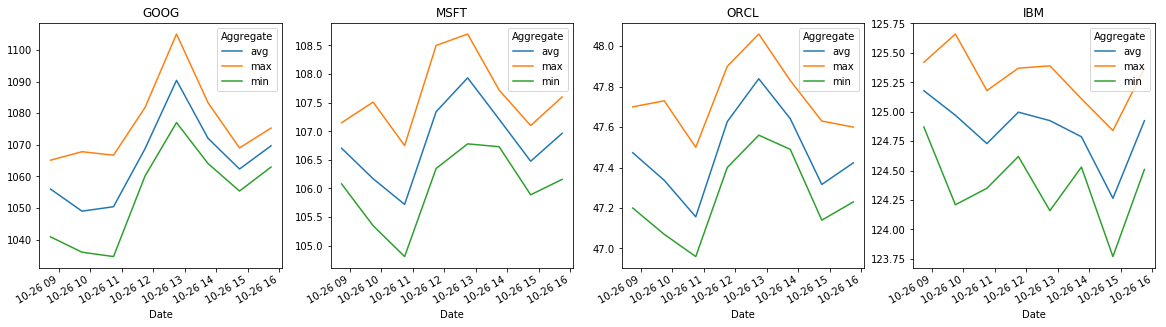

In [55]:
stock_symbols = ['GOOG','MSFT','ORCL','IBM']   
fig, axarr = plt.subplots(1,4)
pricesdf = merged.loc[merged['metric_name']=='price']

for sym, ax in zip(stock_symbols, axarr):
    pricesdf.loc[pricesdf['symbol'] == sym].pivot(columns='Aggregate', values='values').plot(ax=ax, title=sym, figsize=[20,5])

## Read the Twitter + Sentiments feed as Pandas Data Frame
Streaming data generated in by nuclio functions can be read in real-time or historically. <br>It can be distributed to multiple workers for scalability via sharding/partitioning. 

In [8]:
streamdfs = client.read(backend='stream', table='stocks_stream',seek='seq',shard='0', sequence=140)
streamdf = pd.concat(streamdfs, sort=False)
streamdf.head()

,id,created_at,polarity,subjectivity,stream_time,text,user
0,1.055912e+18,Fri Oct 26 19:58:14 +0000 2018,0.000000,0.100000,2018-10-26 19:58:15.290709,@Google @Cut4 Actually mookie betts does bat 1...,@RealJaredTrupp
1,1.055912e+18,Fri Oct 26 19:58:15 +0000 2018,0.000000,0.000000,2018-10-26 19:58:16.213671,@Caibo_ @KEEMSTAR @TeamYouTube @GooglePlus @Go...,@ImANewManFacts
2,1.055912e+18,Fri Oct 26 19:58:16 +0000 2018,-0.083333,0.500000,2018-10-26 19:58:16.652652,@Solmemes1 @LisaMei62 Typically anyone who com...,@lisaraphael31
3,1.055912e+18,Fri Oct 26 19:58:16 +0000 2018,0.136364,0.454545,2018-10-26 19:58:16.791646,RT @Penguinsangel: #ad Time for a new phone? L...,@PhancyPheet
4,1.055912e+18,Fri Oct 26 19:58:16 +0000 2018,0.300000,0.944444,2018-10-26 19:58:16.978638,RT @DodgersNation: Wow ..... RT to make sure t...,@marissahhhill


## Save Any Data "To Go" as a CSV file (or other formats)

In [10]:
streamdf.to_csv('mystream.csv')